# Laplacian, highboost and gradient filtering; combining of the methods

**Author: Uzhva Denis Romanovich**

**Lecturer: Soloviev Igor Pavlovich**

## Laplacian filtering
### Theory

Laplacian filtering is a type of spatial filtering aiming to sharpen an image.
Unlike box or weighted average filtering, which use the concept of an integral, laplacian is based on a derivatives.
Concerning the fact that we process discrete images, the derivatives thus become differences.
E.g., consider the 2-dimensional laplacian operator:
$$
\begin{equation}
\nabla^2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}.
\tag{1}
\end{equation}
$$
Let $A \in \overline{0, 255}^{M \times N}$ be an $M \times N$ matrix of the image, containing values of intensity of corresponding pixels.
Let also $\widehat{A} \in \overline{0, 255}^{M + 2a \times N + 2b}$ be a padded $A$, i.e. $\widehat{A}_{i+a, j + a} = A_{i, j}$.
Then the discrete form of the laplacian would be defined as follows:
$$
\begin{equation}
\nabla^2 \widehat{A}_{i, j} = \widehat{A}_{i+1, j} + \widehat{A}_{i, j+1} + \widehat{A}_{i-1, j} + \widehat{A}_{i, j-1} - 4 \widehat{A}_{i, j},
\tag{2}
\end{equation}
$$
where $i \in \overline{2, M-1}$ and $j \in \overline{2, N-1}$.
Another definition is the following:
$$
\begin{equation}
\nabla^2 \widehat{A}_{i, j} = \widehat{A}_{i+1, j} + \widehat{A}_{i, j+1} + \widehat{A}_{i-1, j} + \widehat{A}_{i, j-1} + \widehat{A}_{i+1, j+1} + \widehat{A}_{i-1, j+1} + \widehat{A}_{i-1, j+1} + \widehat{A}_{i-1, j-1} - 8 \widehat{A}_{i, j},
\tag{3}
\end{equation}
$$
and the main advantage of it over the equation (2) is that it considers diagonals.

Finally, the result of application of the laplacian can be expressed by the following formula:
$$
\begin{equation}
B = A + c \nabla^2 \widehat{A},
\tag{4}
\end{equation}
$$
so that the result is the original image plus the extracted edges (which we want to highlight) times constant $c$, which may vary.

### Code

#### Laplacian filter

In [1]:
import numpy as np


def apply_lapl(img, filt, c=1.):
    h = img.shape[0]
    w = img.shape[1]
    ker_size = filt.shape[0]
    pad_size = (ker_size - 1) // 2
    
    edg_ext = np.zeros_like(img, dtype=float)
   
    if len(img.shape) == 3:
        channels = img.shape[-1]
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size, channels), dtype=float)
        img_padded[pad_size:-pad_size, pad_size:-pad_size, :] = img
    else:
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size), dtype=float)
        img_padded[pad_size:-pad_size, pad_size:-pad_size] = img
    
    for i in range(ker_size):
        for j in range(ker_size):
            ker_multiplier = filt[i, j]
            edg_ext = edg_ext + ker_multiplier * img_padded[i:i+h, j:j+w]
                
    edg_ext = c * edg_ext
    
    img_new = np.zeros_like(img, dtype=float)
    img_new = img + edg_ext
    img_new[img_new > 255] = 255
    img_new[img_new < 0] = 0
    img_new = img_new.astype(np.uint8)
    
    return img_new, edg_ext

#### Make laplacian kernel

In [2]:
import numpy as np


def get_laplacian_kernel(diag=False):
    kernel = np.zeros((3, 3))
    if diag:
        kernel[:, :] = 1
        kernel[1, 1] = -8
    else:
        kernel[1, :] = 1
        kernel[:, 1] = 1
        kernel[1, 1] = -4
            
    return kernel

### Results

#### Processing + visualization

First of all, we need to load images for the further processing:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# https://academic.oup.com/ptp/article/79/1/39/1855689
img_1 = Image.open('./text1.jpg')
# https://academic.oup.com/ptp/article/79/1/39/1855689
img_2 = Image.open('./text2.jpg')

In [4]:
# represent the images as tensors
np_1 = np.array(img_1)
np_2 = np.array(img_2)
print('Picture dimensions:')
print(np_1.shape)
print(np_2.shape)

Picture dimensions:
(227, 488, 3)
(314, 300, 3)


In [70]:
# get the kernels
lap4 = get_laplacian_kernel(diag=False)
lap8 = get_laplacian_kernel(diag=True)

Apply laplacian filtering for the 1st image:

In [6]:
np_1_l4_c1, np_1_l4_c1_edg = apply_lapl(np_1, lap4, c=1.)
np_1_l4_cm1, np_1_l4_cm1_edg = apply_lapl(np_1, lap4, c=-1.)
np_1_l8_c1, np_1_l8_c1_edg = apply_lapl(np_1, lap8, c=1.)
np_1_l8_cm1, np_1_l8_cm1_edg = apply_lapl(np_1, lap8, c=-1.)

1st image before and after the laplacian filtering:

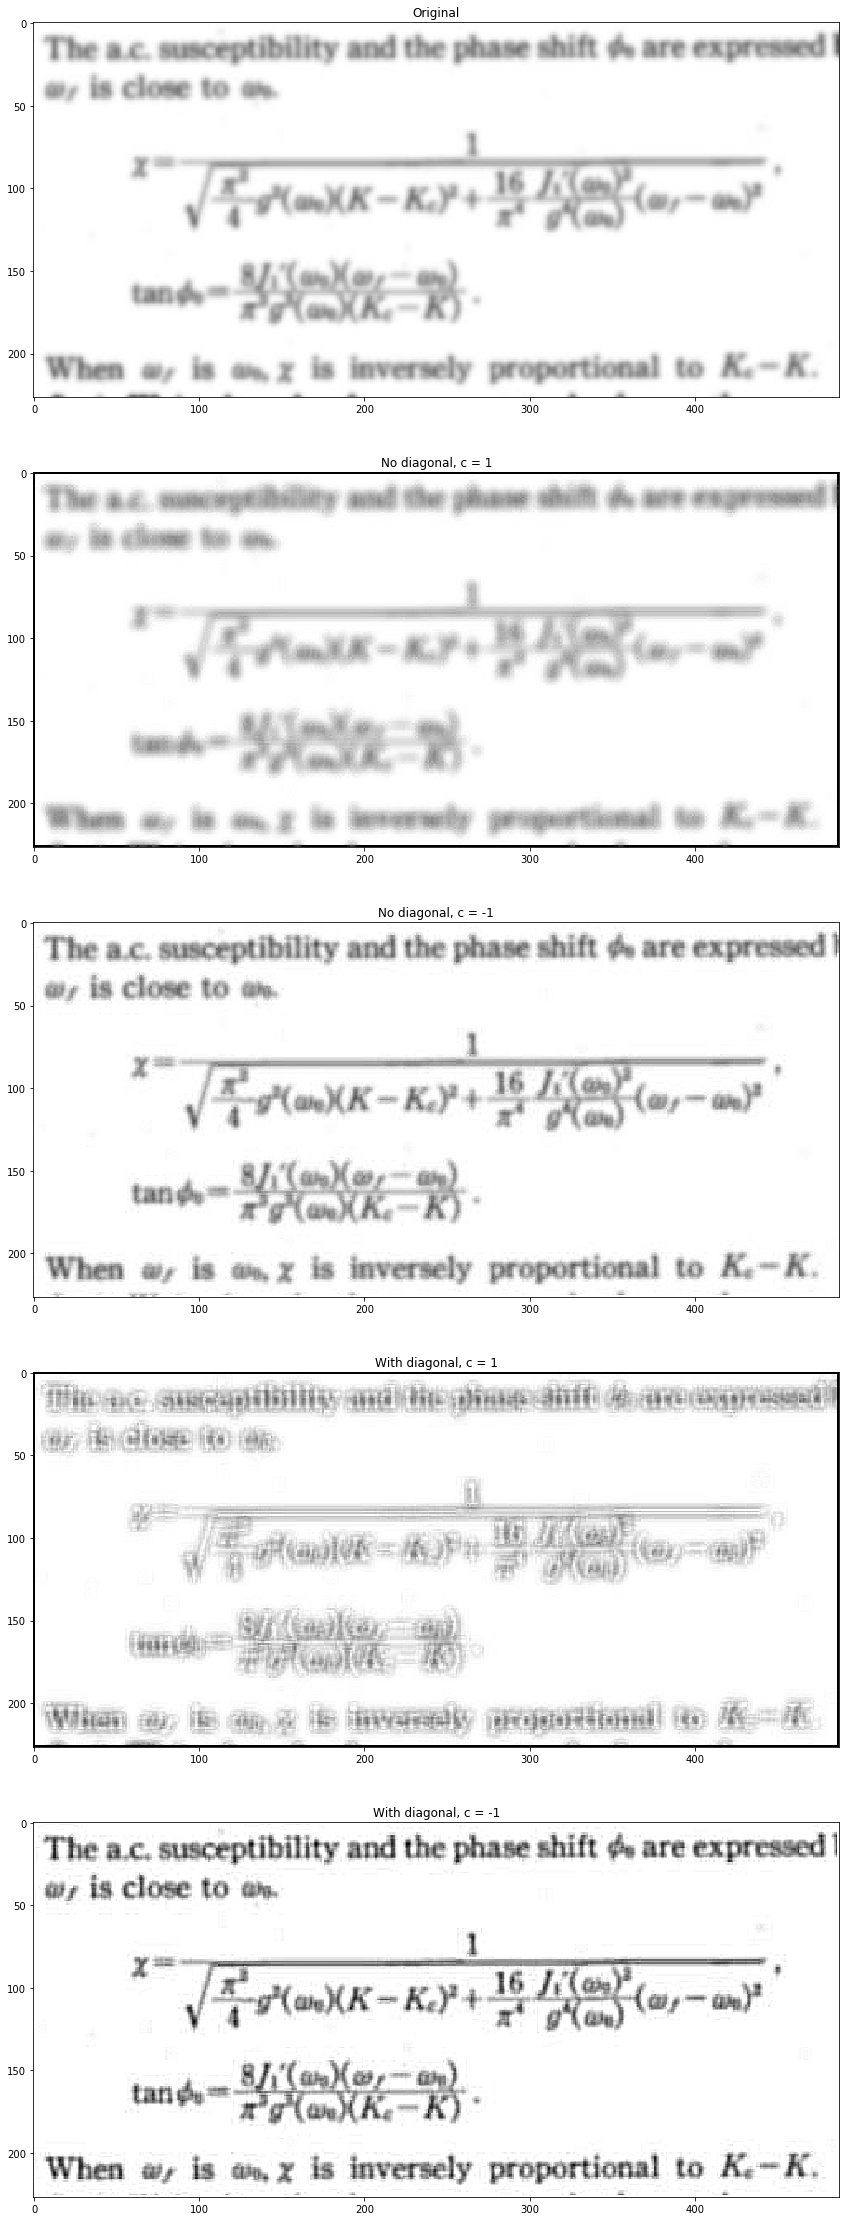

In [7]:
fig, axs = plt.subplots(5, 1, figsize=(200, 40))
axs[0].imshow(np_1)
axs[0].set_title('Original')
axs[1].imshow(np_1_l4_c1)
axs[1].set_title('Laplacian without diagonal, c = 1')
axs[2].imshow(np_1_l4_cm1)
axs[2].set_title('Laplacian without diagonal, c = -1')
axs[3].imshow(np_1_l8_c1)
axs[3].set_title('Laplacian with diagonal, c = 1')
axs[4].imshow(np_1_l8_cm1)
axs[4].set_title('Laplacian with diagonal, c = -1')
plt.show()

Since the kernel with diagonals showed best results, it is reasonable to use it further.

Consider different negative constants $c$:

In [11]:
np_1_l8_cm1_5, np_1_l8_cm1_5_edg = apply_lapl(np_1, lap8, c=-1.5)
np_1_l8_cm2_5, np_1_l8_cm2_5_edg = apply_lapl(np_1, lap8, c=-2.5)
np_1_l8_cm3_5, np_1_l8_cm3_5_edg = apply_lapl(np_1, lap8, c=-3.5)

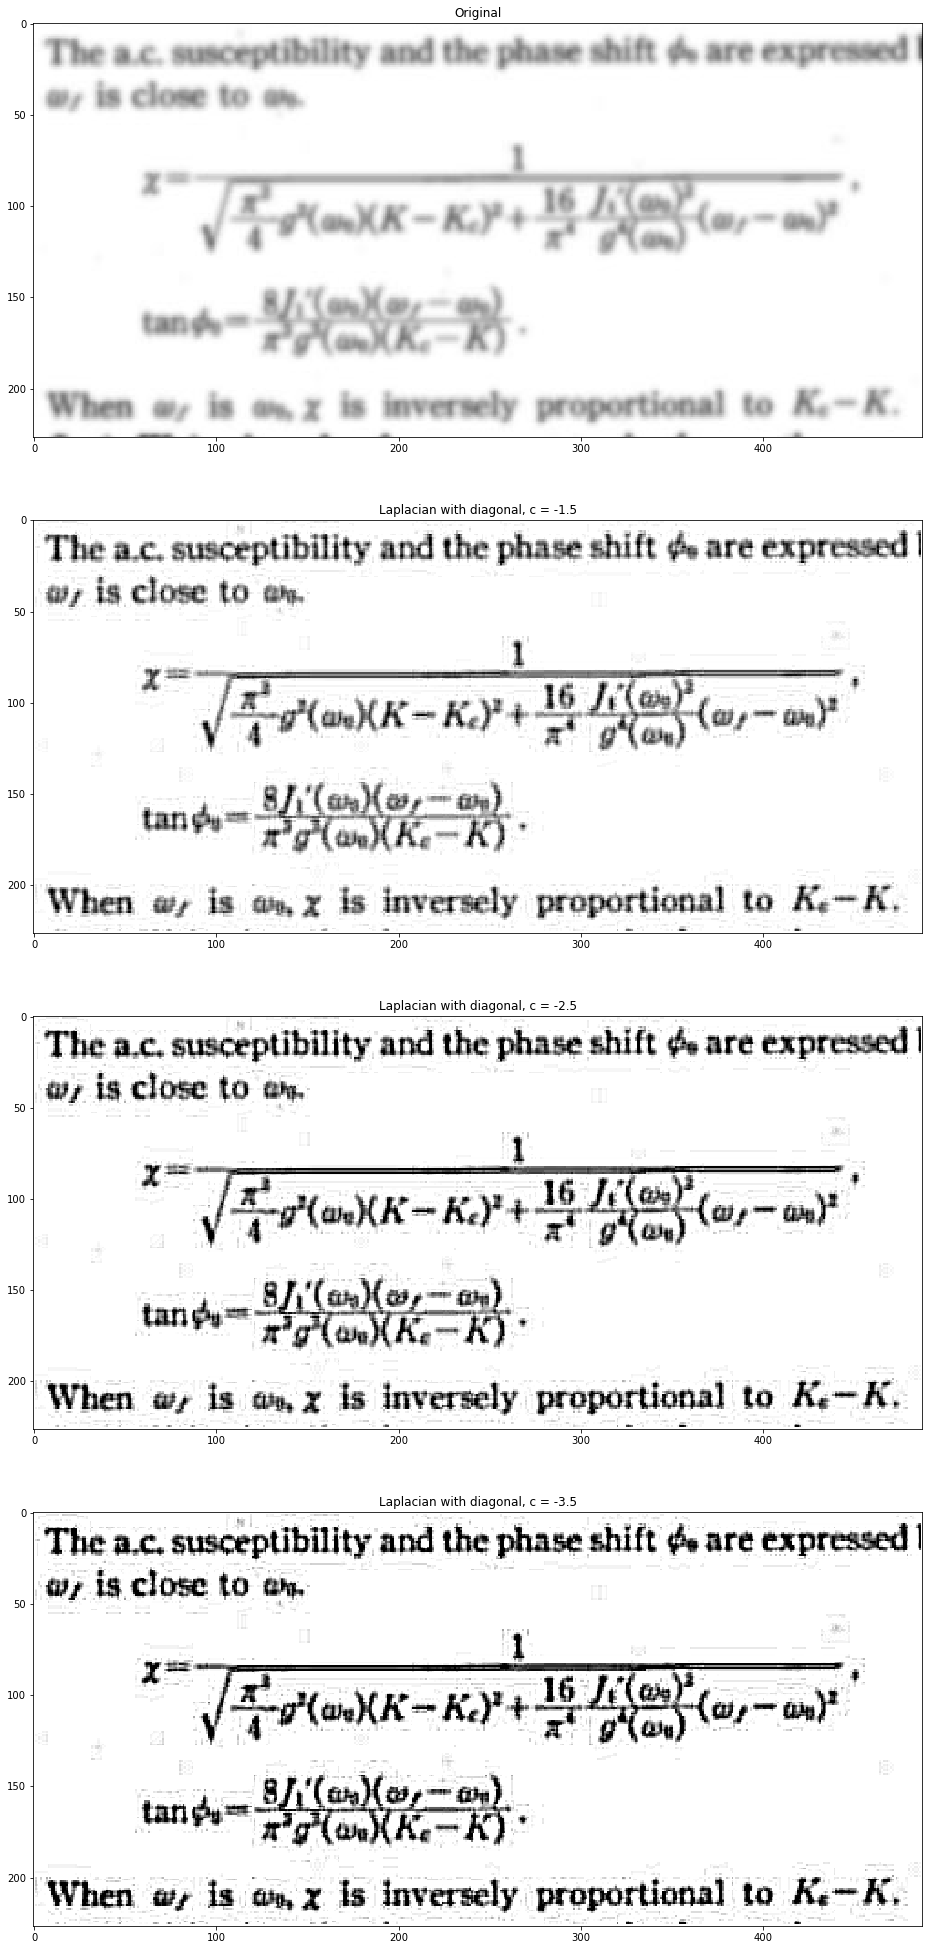

In [35]:
fig, axs = plt.subplots(4, 1, figsize=(120, 35))
axs[0].imshow(np_1)
axs[0].set_title('Original')
axs[1].imshow(np_1_l8_cm1_5)
axs[1].set_title('Laplacian with diagonal, c = -1.5')
axs[2].imshow(np_1_l8_cm2_5)
axs[2].set_title('Laplacian with diagonal, c = -2.5')
axs[3].imshow(np_1_l8_cm3_5)
axs[3].set_title('Laplacian with diagonal, c = -3.5')
plt.show()

At the value $c = -2.5$ the result appears to be the best, since it sufficiently increases readability of the text with less artifacts added than that with $c = -3.5$.

Let's process the second image:

In [14]:
np_2_l8_cm1_5, np_2_l8_cm1_5_edg = apply_lapl(np_2, lap8, c=-1.5)
np_2_l8_cm2_5, np_2_l8_cm2_5_edg = apply_lapl(np_2, lap8, c=-2.5)
np_2_l8_cm3_5, np_2_l8_cm3_5_edg = apply_lapl(np_2, lap8, c=-3.5)

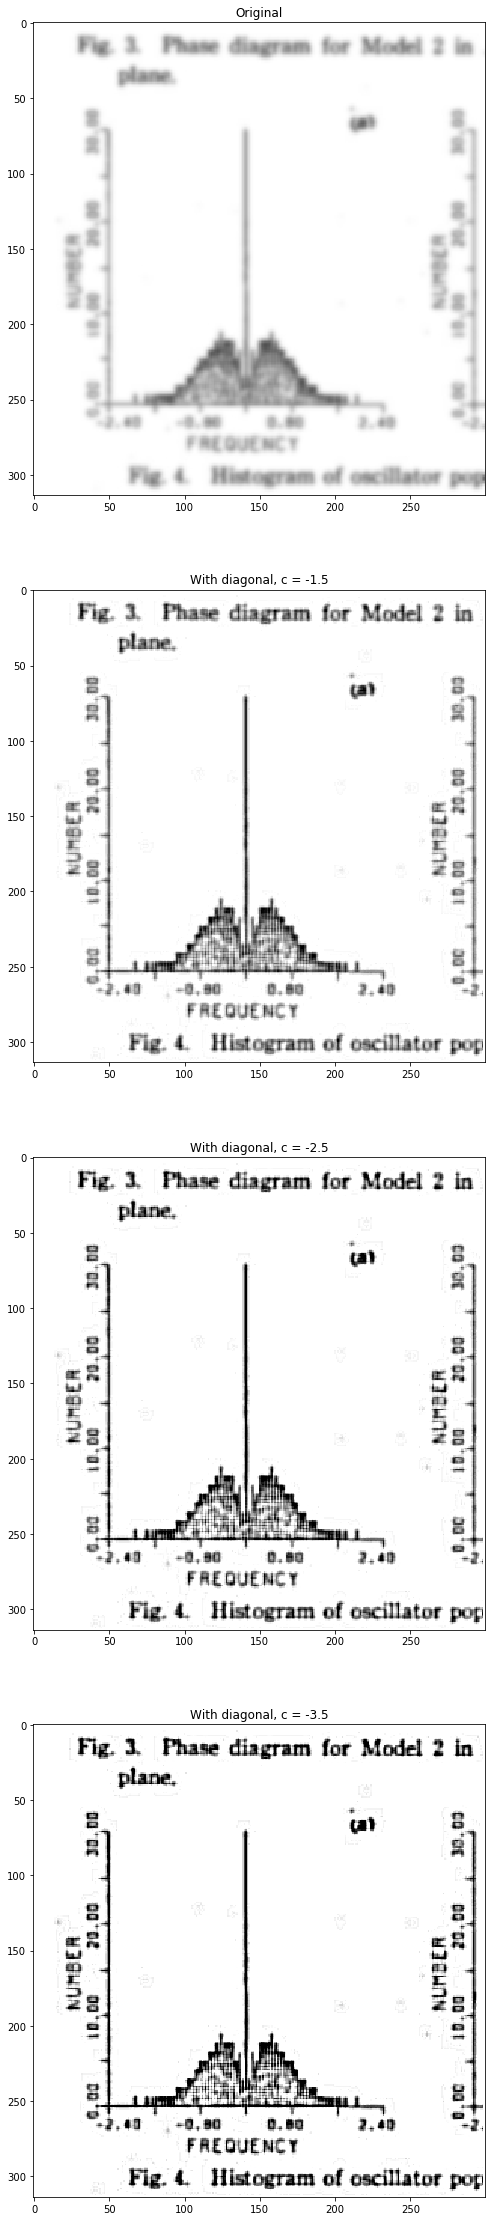

In [15]:
fig, axs = plt.subplots(4, 1, figsize=(120, 40))
axs[0].imshow(np_2)
axs[0].set_title('Original')
axs[1].imshow(np_2_l8_cm1_5)
axs[1].set_title('Laplacian with diagonal, c = -1.5')
axs[2].imshow(np_2_l8_cm2_5)
axs[2].set_title('Laplacian with diagonal, c = -2.5')
axs[3].imshow(np_2_l8_cm3_5)
axs[3].set_title('Laplacian with diagonal, c = -3.5')
plt.show()

In this case it seems that the $c = -2.5$ is not enough to restore the image sufficiently. At $c = -3.5$ the result is most satisfactory.

## Highboost filtering
### Theory

The main idea is very simple: create a blurred version of an image, subtract it from the original one and finally add the result of subtraction with some weight.
The corresponding set of equations is as follows:
$$
\begin{equation}
S = A - \overline{A},
\tag{1}
\end{equation}
$$
$$
\begin{equation}
G = A + k S,
\tag{2}
\end{equation}
$$
where $A$ is an original image, $\overline{A}$ is its blurred version and $k$ is some coefficient (weight).

### Code

#### Box filter

In [16]:
import numpy as np


def apply_box(img, ker_size=3):
    h = img.shape[0]
    w = img.shape[1]
    pad_size = (ker_size - 1) // 2
    mul = 1 / (ker_size * ker_size)
    
    img_new = np.zeros_like(img, dtype=float)
    
    if len(img.shape) == 3:
        channels = img.shape[-1]
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size, channels), dtype=float)
        img_padded[pad_size:-pad_size, pad_size:-pad_size, :] = img
    else:
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size), dtype=float)
        img_padded[pad_size:-pad_size, pad_size:-pad_size] = img
    
    for i in range(ker_size):
        for j in range(ker_size):
            img_new = img_new + mul * img_padded[i:i+h, j:j+w]
                
    img_new[img_new > 255] = 255
    img_new[img_new < 0] = 0
    img_new = img_new.astype(np.uint8)
                
    return img_new

#### Highboost filter

In [22]:
import numpy as np


def apply_hboost(img, k=1., ker_size=3):
    img_box = apply_box(img, ker_size)
    img_s = img.astype(float) - img_box.astype(float)
    img_new = img.astype(float) + k * img_s
    img_new[img_new > 255] = 255
    img_new[img_new < 0] = 0
    img_new = img_new.astype(np.uint8)
    
    return img_new

### Results

#### Processing + visualization

Apply highboost filtering for the 1st image:

In [32]:
np_1_hb3_k1 = apply_hboost(np_1, k=1.)
np_1_hb3_k5 = apply_hboost(np_1, k=5.)
np_1_hb3_k11 = apply_hboost(np_1, k=11.)
np_1_hb3_k15 = apply_hboost(np_1, k=15.)

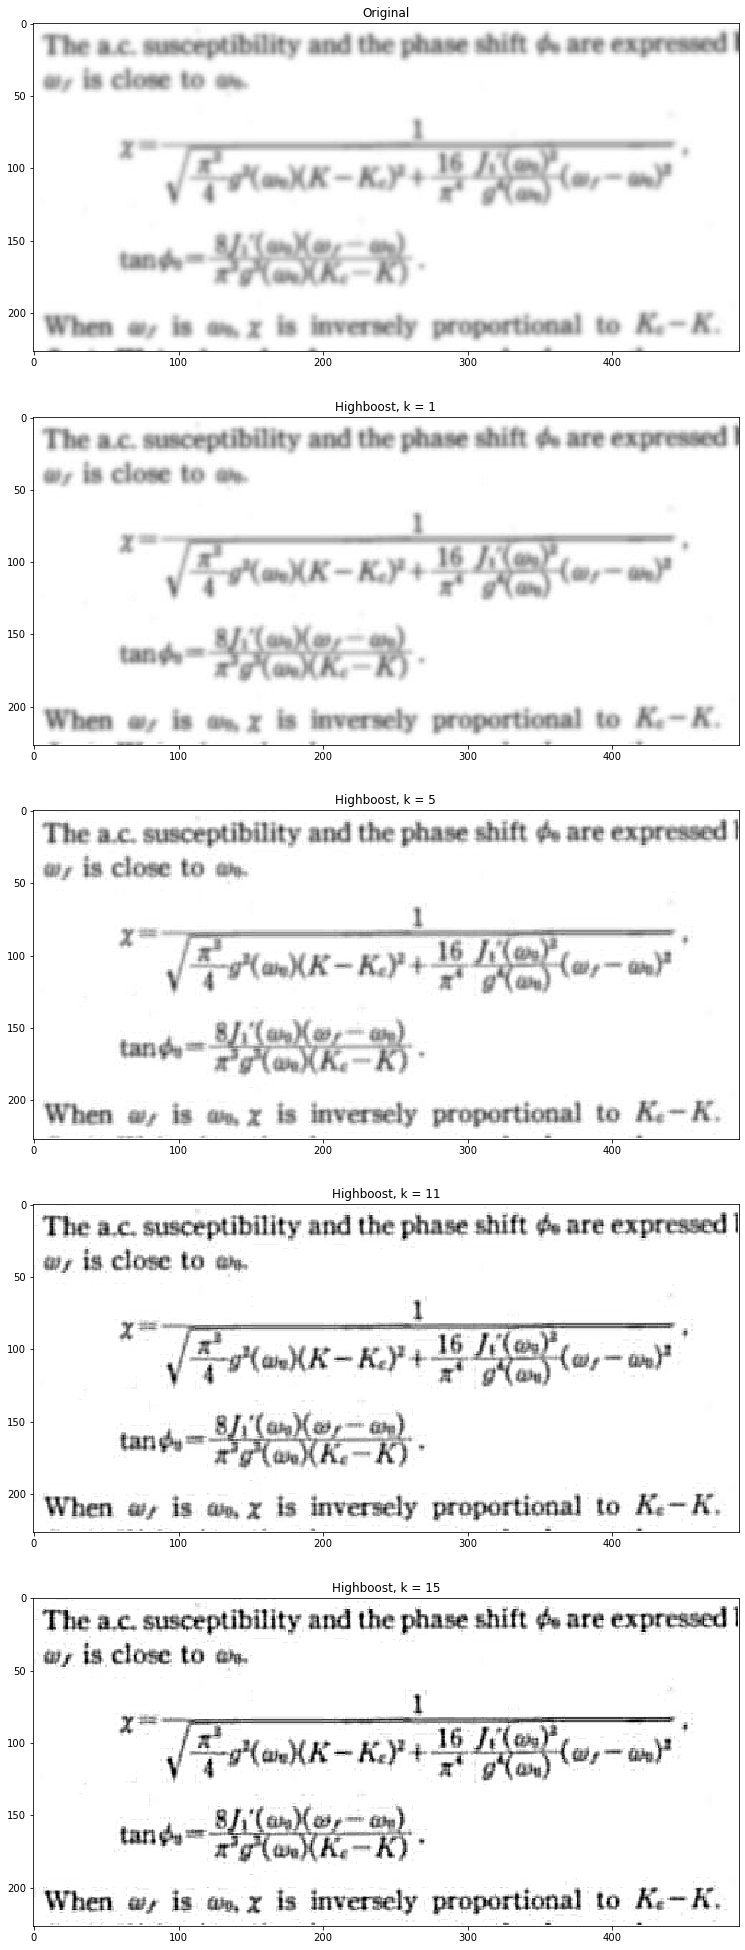

In [34]:
fig, axs = plt.subplots(5, 1, figsize=(120, 35))
axs[0].imshow(np_1)
axs[0].set_title('Original')
axs[1].imshow(np_1_hb3_k1)
axs[1].set_title('Highboost, k = 1')
axs[2].imshow(np_1_hb3_k5)
axs[2].set_title('Highboost, k = 5')
axs[3].imshow(np_1_hb3_k11)
axs[3].set_title('Highboost, k = 11')
axs[4].imshow(np_1_hb3_k15)
axs[4].set_title('Highboost, k = 15')
plt.show()

It is noticeable that at relatively high values of $k$ (around 11-15) the highboost filter successfully manages to enhance readability of the text. This filter is "smoother" in some sense than the one based on the laplacian. It is also faster than the laplacian filter.

Let's enhance the 2nd image with the higboost filter:

In [36]:
np_2_hb3_k11 = apply_hboost(np_2, k=11.)
np_2_hb3_k15 = apply_hboost(np_2, k=15.)

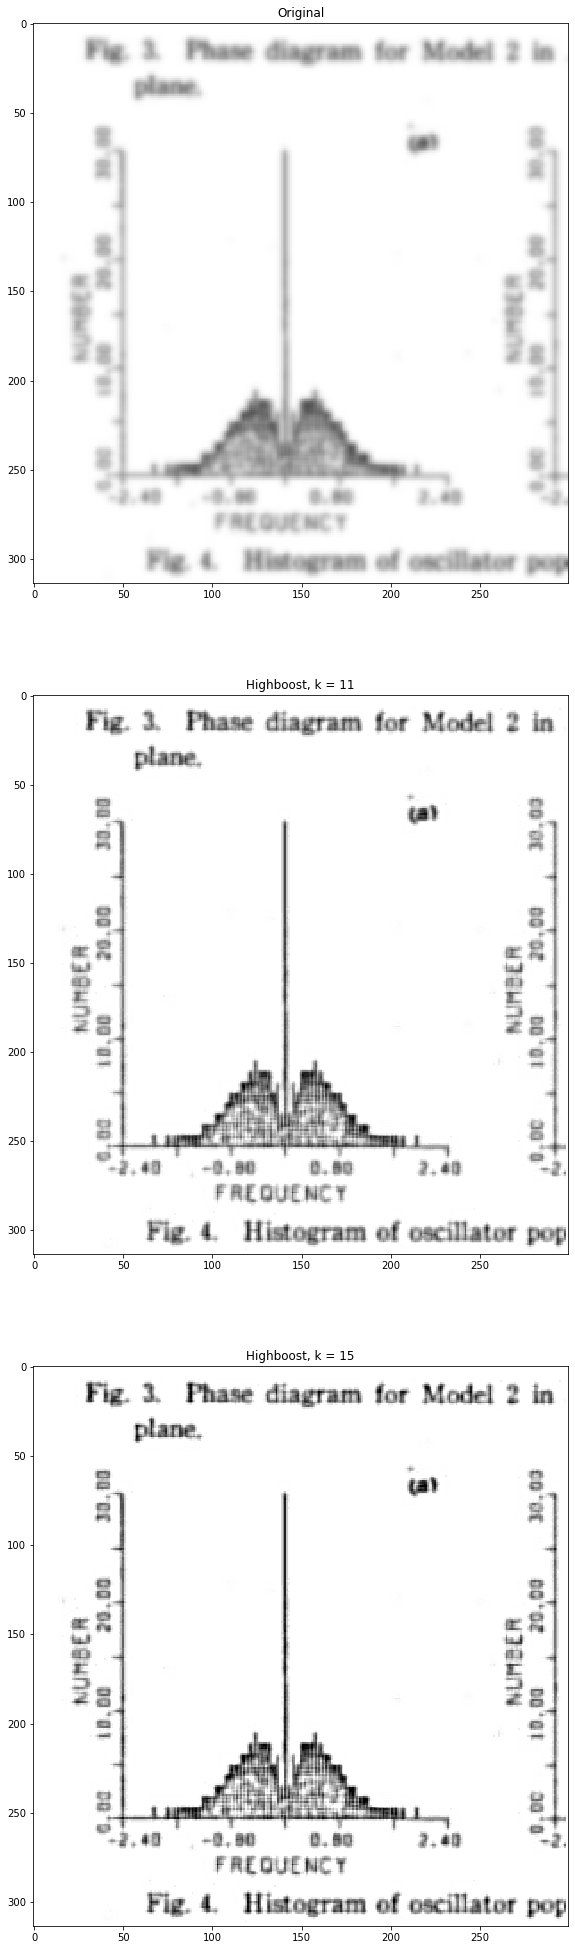

In [37]:
fig, axs = plt.subplots(3, 1, figsize=(120, 35))
axs[0].imshow(np_2)
axs[0].set_title('Original')
axs[1].imshow(np_2_hb3_k11)
axs[1].set_title('Highboost, k = 11')
axs[2].imshow(np_2_hb3_k15)
axs[2].set_title('Highboost, k = 15')
plt.show()

There one may see that the highboost filter demonstrates slightly worse quality of sharpening in comparison with the laplacian filter.

## Gradient filtering
### Theory

Likewise the laplacian filtering, one may consider so-called gradient filtering.
Its purpose is to extract edges for further processing.

Consider a 3x3 mask. 
Then corresponging approximate discrete gradients would be as follows:
$$
\begin{equation}
g_x = \frac{\partial f}{\partial x} = (z_7 + 2 z_8 + z_9) - (z_1 + 2 z_2 + z_3),
\tag{1}
\end{equation}
$$
$$
\begin{equation}
g_y = \frac{\partial f}{\partial y} = (z_3 + 2 z_6 + z_9) - (z_1 + 2 z_4 + z_7),
\tag{2}
\end{equation}
$$
where $f$ is a function corresponding to an image ($f(x, y)$), $z_1 ... z_9$ is the enumeration of a 3x3 neighborhood of a poit $(x, y)$ (from left to right, top down).
With that in mind, one may obtain a final equation of a processed image:
$$
\begin{equation}
M(x, y) \approx \mid (z_7 + 2 z_8 + z_9) - (z_1 + 2 z_2 + z_3) \mid + \mid (z_3 + 2 z_6 + z_9) - (z_1 + 2 z_4 + z_7) \mid.
\tag{3}
\end{equation}
$$

### Code

#### Gradient filtering

In [44]:
import numpy as np


def apply_grad(img):
    h = img.shape[0]
    w = img.shape[1]
    ker_size = 3
    pad_size = (ker_size - 1) // 2
    
    filt_x = np.zeros((3, 3))
    filt_x[0, 0] = -1
    filt_x[0, 2] = -1
    filt_x[0, 1] = -2
    filt_x[2, 0] = 1
    filt_x[2, 2] = 1
    filt_x[2, 1] = 2   
    filt_y = np.rot90(filt_x)
    
    img_new_1 = np.zeros_like(img, dtype=float)
    img_new_2 = np.zeros_like(img, dtype=float)
   
    if len(img.shape) == 3:
        channels = img.shape[-1]
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size, channels), dtype=float)
        img_padded[pad_size:-pad_size, pad_size:-pad_size, :] = img
    else:
        img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size), dtype=float)
        img_padded[pad_size:-pad_size, pad_size:-pad_size] = img
    
    for i in range(ker_size):
        for j in range(ker_size):
            ker_multiplier = filt_x[i, j]
            img_new_1 = img_new_1 + ker_multiplier * img_padded[i:i+h, j:j+w]
            
    for i in range(ker_size):
        for j in range(ker_size):
            ker_multiplier = filt_y[i, j]
            img_new_2 = img_new_2 + ker_multiplier * img_padded[i:i+h, j:j+w]
                
    img_new = np.abs(img_new_1) + np.abs(img_new_2)
    img_new[img_new > 255] = 255
    img_new = img_new.astype(np.uint8)
    
    return img_new

### Results

#### Processing + visualization

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# https://www.ial-fa.com/failure-analysis/integrated-circuits
img_3 = Image.open('./int.jpg')

In [40]:
# represent the images as tensors
np_3 = np.array(img_3)
print('Picture dimensions:')
print(np_3.shape)

Picture dimensions:
(538, 750, 3)


In [45]:
np_3_g = apply_grad(np_3)

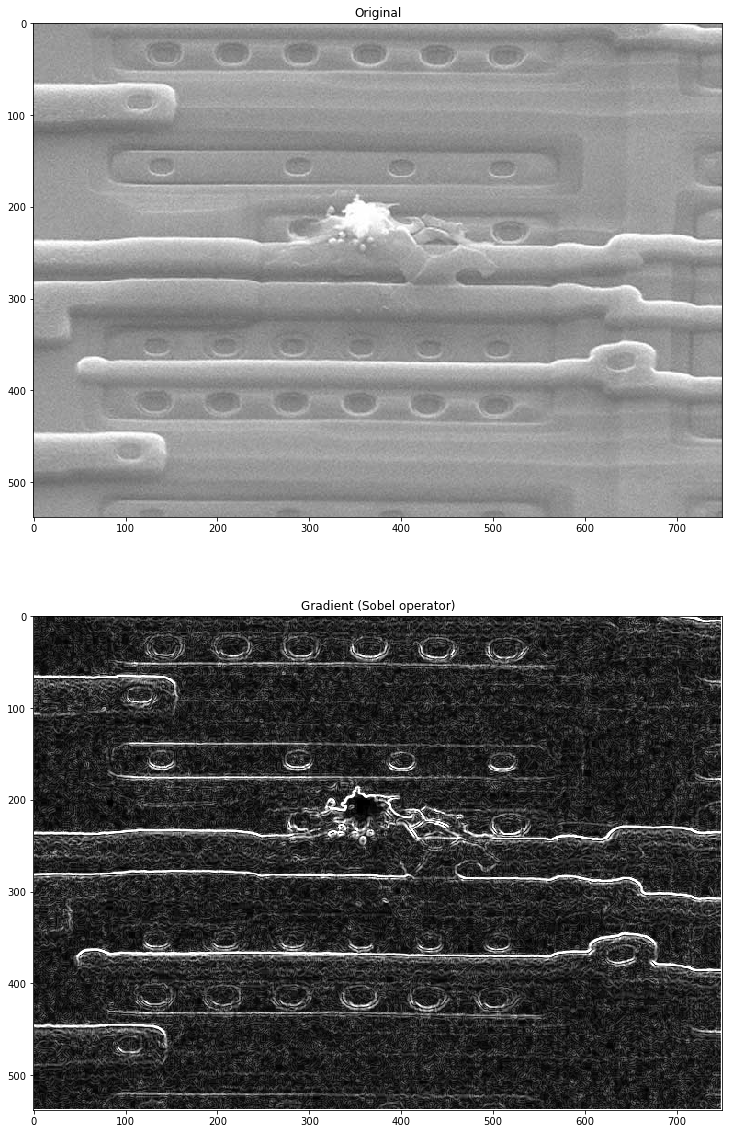

In [47]:
fig, axs = plt.subplots(2, 1, figsize=(90, 20))
axs[0].imshow(np_3)
axs[0].set_title('Original')
axs[1].imshow(np_3_g)
axs[1].set_title('Gradient (Sobel operator)')
plt.show()

After the processing, it is clearly seen that a cirquit has a defect.

## Combining the methods
### Theory

In order to obtain satisfactory results, it is necessary to use multiple methods of image processing.
One example of such combination is considered below

### Results 

#### Processing + visualization

Load an image of Phobos (a satellite of Mars):

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# https://www.ial-fa.com/failure-analysis/integrated-circuits
img_4 = Image.open('./phobos.jpg')

In [73]:
# represent the images as tensors
np_4 = np.array(img_4)
print('Picture dimensions:')
print(np_4.shape)

Picture dimensions:
(1080, 1920, 3)


Plot the original image:

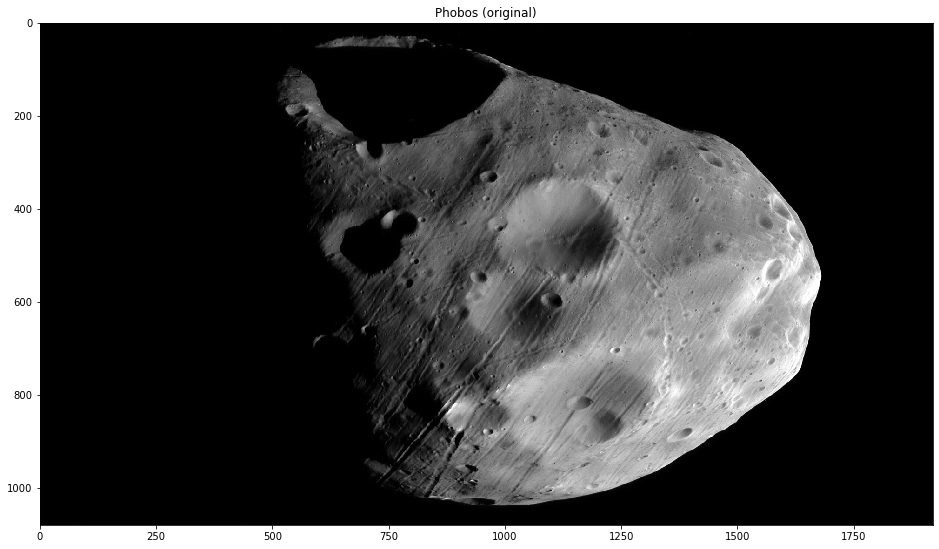

In [54]:
plt.figure(figsize=(16, 16))
plt.imshow(np_4)
plt.title('Phobos (original)')
plt.show()

First of all, lets re-define the previous transformations:

In [58]:
import numpy as np


def power_transform(img, c=1., gamma=1.):
    
    img_norm = img / 255.
    img_norm_new = c * np.power(img_norm, gamma)
    if img_norm_new.max() > 1.:
        img_norm_new = img_norm_new / img_norm_new.max()
    img_new = img_norm_new * 255
        
    img_new = img_new.astype(np.uint8)
    return img_new

In [64]:
import numpy as np


def im_hist_np(img, normalize=True):
    Lm1 = 256
    if len(img.shape) == 3:
        channels = img.shape[-1]
        hist_arr = np.zeros((channels, Lm1), dtype=float)
        for ch in range(channels):
            hist_arr[ch, :] = np.histogram(img[:, :, ch].flatten(), bins=np.arange(Lm1 + 1))[0]
    else:
        hist_arr = np.histogram(img.flatten(), bins=np.arange(Lm1 + 1))[0].astype(float)
        
    if normalize:
        h = img.shape[0]
        w = img.shape[1]
        hist_arr /= (h * w)
        
    return hist_arr

In [65]:
import numpy as np


def eq_uniform(img, hist_arr):
    h = img.shape[0]
    w = img.shape[1]
    Lm1 = 256
    
    img_new = np.zeros_like(img)
    
    if len(img.shape) == 3:
        for rk in range(Lm1):
            where_rk = np.argwhere(img == rk)
            where_rk_bin = img == rk
            hist_sum_k = np.sum(hist_arr[:, :rk], axis=1)
            #print(where_rk[:, 2])
            img_new[where_rk_bin] = Lm1 * hist_sum_k[where_rk[:, 2]]
    else:
        for rk in range(Lm1):
            where_rk_bin = img == rk
            hist_sum_k = np.sum(hist_arr[:rk])
            img_new[where_rk_bin] = Lm1 * hist_sum_k
            
    img_new = img_new.astype(np.uint8)
    return img_new

First of all, let's apply laplacian filtering:

In [102]:
np_4_1, _ = apply_lapl(np_4, lap8, c=-1.7)

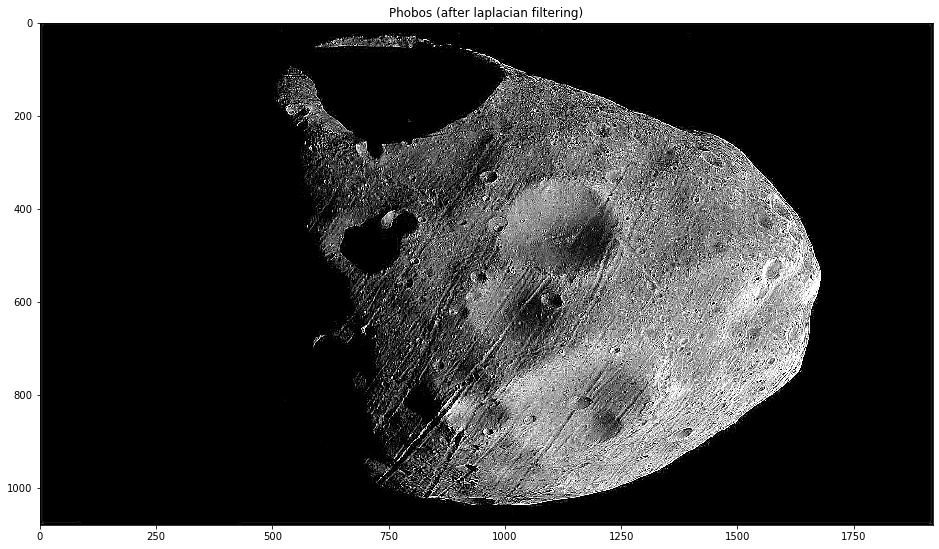

In [103]:
plt.figure(figsize=(16, 16))
plt.imshow(np_4_1)
plt.title('Phobos (after laplacian filtering)')
plt.show()

Next, apply gamma transformation:

In [104]:
np_4_2 = power_transform(np_4_1, 1., 0.6)

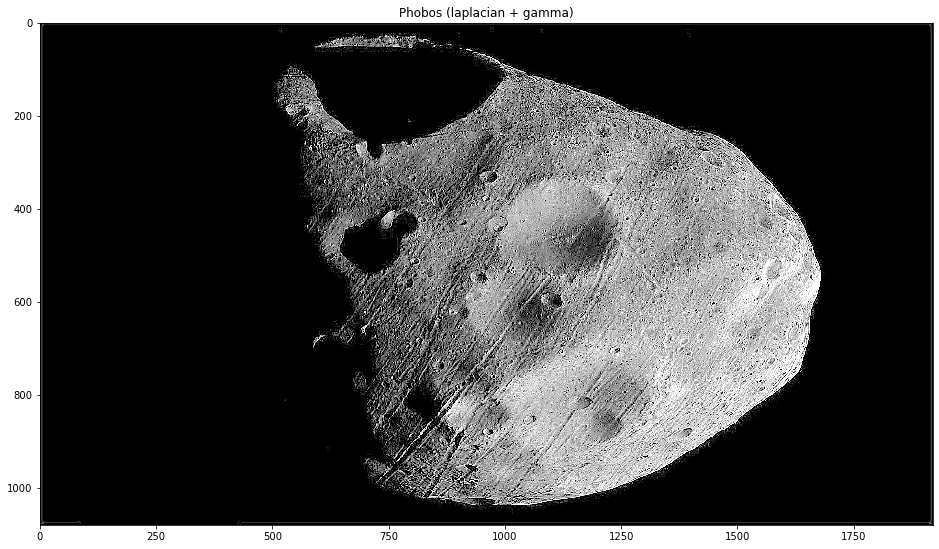

In [105]:
plt.figure(figsize=(16, 16))
plt.imshow(np_4_2)
plt.title('Phobos (laplacian + gamma)')
plt.show()

Now smoothen the image a little with the box filter:

In [106]:
np_4_3 = apply_box(np_4_2, 3)

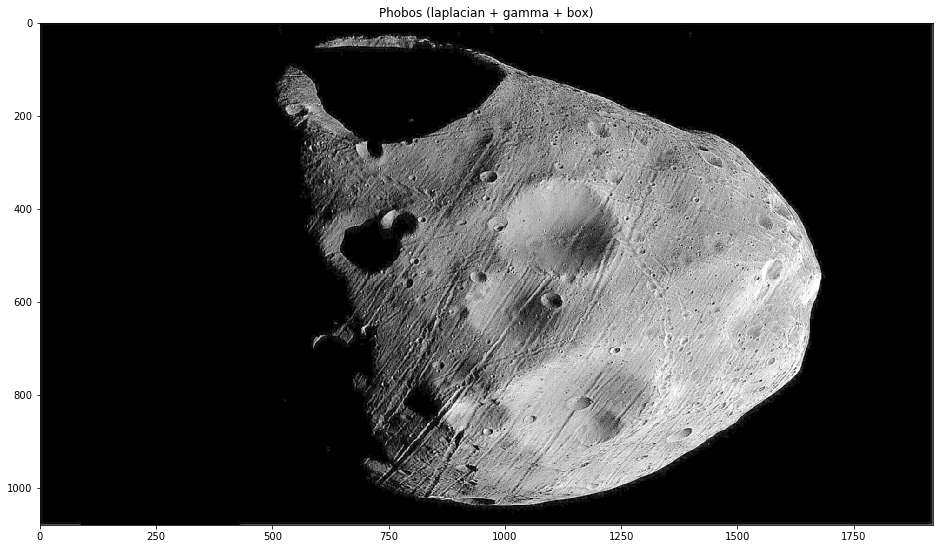

In [107]:
plt.figure(figsize=(16, 16))
plt.imshow(np_4_3)
plt.title('Phobos (laplacian + gamma + box)')
plt.show()

As a result, there appeared more details in the surface of Phobos.